In [25]:
import nltk
from nltk import word_tokenize
import simplejson as json
import sklearn
from sklearn.feature_extraction.text import * 
from sklearn.model_selection import train_test_split 

from sklearn import linear_model 
from sklearn import metrics 

import numpy as np
import matplotlib.pyplot as plt

import re 

import sys
sys.path.insert(0, '../preprocessing/')

from combineMultipleDatasets import getAllText, getAllVocabulary, getAllText2

from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

In [11]:
def logistic_classification():
    # trains and test logistic classification model for simple topic classification between covid and non-covid related raw text

#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_fraction, random_state=42)
    X_train, Y_train, vectorizerTrain = getAllText2(isTrain=True)
    ### CUT DOWN TO HAVE SAME AMOUNT OF FEATURES AS X_TEST
    X_train = X_train[:, :4519]
    print(X_train.shape)
    print(Y_train.shape)
    X_test, Y_test, vectorizerTest = getAllText2(isTrain=False)
    print(X_test.shape)
    print(Y_test.shape)
    #  set the state of the random number generator so that we get the same results across runs when testing our code

    print('Number of training examples: ', X_train.shape[0])
    print('Number of testing examples: ', X_test.shape[0])
    print('Vocabulary size: ', X_train.shape[1])


    # Specify the logistic classifier model with an l2 penalty for regularization and with fit_intercept turned on
    classifier = linear_model.LogisticRegression(penalty='l2', fit_intercept=True)

    # Train a logistic regression classifier and evaluate accuracy on the training data
    print('\nTraining a model with', X_train.shape[0], 'examples.....')
    # fit classification model
    classifier.fit(X_train, Y_train)
    train_predictions = classifier.predict(X_train)
    train_accuracy = metrics.accuracy_score(Y_train, train_predictions)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') )

    # Compute and print accuracy and AUC on the test data
    print('\nTesting: ')
    test_predictions = classifier.predict(X_test)
    test_accuracy = metrics.accuracy_score(Y_test, test_predictions)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )

    # get class_probabilities for class 1
    class_probabilities = classifier.predict_proba(X_test)[:, 1]
    test_auc_score = metrics.roc_auc_score(Y_test, class_probabilities)
    print(' AUC value:', format( 100*test_auc_score , '.2f') )

    return(classifier)

In [12]:
logistic_classifier = logistic_classification() 


Extracting tokens....

Extracting tokens....
(30555, 4519)
(30555,)

Extracting tokens....

Extracting tokens....
(3193, 4519)
(3193,)
Number of training examples:  30555
Number of testing examples:  3193
Vocabulary size:  4519

Training a model with 30555 examples.....

Training:
 accuracy: 100.00

Testing: 
 accuracy: 78.33
 AUC value: 69.41


In [29]:
class SimpleGeneralNeuralNet(nn.Module):
    # Simple Feed Forward Neural Network with One Hidden Layer that Outputs Multiple Neurons (can handle more than 2 classes)
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleGeneralNeuralNet, self).__init__()
        #Written based off of the tutorial at
        #https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/feedforward_neural_network/main.py#L37-L49
        self.hidden1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()   
        self.hOutput1 = nn.Linear(hidden_size, num_classes)  
        self.softmax = nn.Softmax(dim = 0)

    def forward(self, x):
        out = self.hidden1(x)
        out = self.relu(out)
        out = self.hOutput1(out)
#         out = self.softmax(out)
        return out

In [30]:
def trainSimpleModel(num_epochs = 5, learning_rate = 0.001, print_epoch_mod = 5):
    '''
    gets around 63-71% for corona and Liar datasets, around 80-83% on FNN
    
    used this article for help in writing the tensor parts of code so it works with the model
    https://medium.com/analytics-vidhya/part-1-sentiment-analysis-in-pytorch-82b35edb40b8
    Train and tests, calculates both training and test accuracy, models that use SimpleGeneralNeuralNet.
    Specifically only trains and tests the model using data that is specifically for the 
    topic classification between covid and non-covid related raw text
    '''
    DEBUG_MODE = False

    torch.manual_seed(1)
#     if dataset == 'corona':
#         X,Y = getCoronaText() #this function will give us the text array (not document term matrix) and Y
#         X_train,Y_train, vectorizer_train = getCoronaVocabulary(True)
#     elif dataset == 'liar':
#         X,Y = getLiarText()
#         X_train,Y_train, vectorizer_train = getLiarVocabulary(True)
#     elif dataset == 'fnn':
#         X,Y = getFNNText()
#         X_train,Y_train, vectorizer_train = getFNNVocabulary(True)

    X, Y, vectorizer_test = getAllText()
    X_train, Y_train, vectorizer_train = getAllVocabulary(True)
    
    #transform our testing dataset to match the vocabulary for the training dataset
    #transform will return the document-term matrix for X based on training dataset
    x_test = vectorizer_train.transform(X)
    
    #sample test on logistic classifier
    '''classifier = LogisticRegression()
    classifier.fit(X_train,Y_train)
    score = classifier.score(x_test,Y)
    print(score)'''
    
    vocabsize = X_train.shape[1]
    
    
    # transform our training and test data into tensors for the classifier to learn off of
    X_tensor = torch.from_numpy(X_train.todense()).float()
    Y_tensor = torch.from_numpy(np.array(Y_train))
    
    X_test_tensor = torch.from_numpy(x_test.todense()).float()
    Y_test_tensor = torch.from_numpy(np.array(Y))
    
    device = torch.device("cpu")
    # use TensorDataset to be able to use our DataLoader
    train_data = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
    # train_loader = torch.utils.data.DataLoader(train_data,batch_size=16, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=16, shuffle=False)
    
    test_data = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
    # test_loader = torch.utils.data.DataLoader(test_data,batch_size=16, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=16, shuffle=False)
    
    #initialize our model
    model = SimpleGeneralNeuralNet(vocabsize, 200, 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (x_batch, labels) in enumerate(train_loader):
    
            # Forward pass
            # The forward process computes the loss of each iteration on each sample
            model.train()
            y_pred = model(x_batch)
            #need to transform labels to long datatype using .long() or it complains it's an int
            loss = criterion(y_pred, labels.long())
    
            # Backward pass, using the optimizer to update the parameters
            optimizer.zero_grad()
            loss.backward()    #compute gradients
            optimizer.step()   #initiate gradient descent
    
     
            # Below, an epoch corresponds to one pass through all of the samples.
            # Each training step corresponds to a parameter update using 
            # a gradient computed on a minibatch of 100 samples
            if DEBUG_MODE:
                if (i + 1) % print_epoch_mod == 0: 
                    # leaving it on 5 for corona dataset, probably want to change to % 50 or % 100
                    # for the other datasets so don't get spammed 
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    
    # Test the model
    # In the test phase, we don't need to compute gradients (the model has already been learned)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test accuracy of the network: {} %'.format(100 * correct / total))
        test_accuracy = 100 * correct / total
        
    # Print out training accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Train accuracy of the network: {} %'.format(100 * correct / total))
        train_accuracy = 100 * correct / total

#     return train_loader, test_loader, model
    return test_accuracy, train_accuracy, model, vectorizer_train

In [31]:
test_accuracy, train_accuracy, model, vectorizer_train = trainSimpleModel(num_epochs=30)


Extracting tokens....

Extracting tokens....

Extracting tokens....

Extracting tokens....
Data shape for text:  (30555, 4932)
Test accuracy of the network: 98.12088944566239 %
Train accuracy of the network: 100.0 %


In [32]:
import pickle

In [33]:
torch.save(model, 'general_saved_model')
pickle.dump(vectorizer_train, open('general_vec.pkl', 'wb'))

In [15]:
test_accuracy, train_accuracy = trainSimpleModel()


Extracting tokens....

Extracting tokens....

Extracting tokens....

Extracting tokens....
Data shape for text:  (30555, 4932)
Test accuracy of the network: 90.72972126526777 %
Train accuracy of the network: 99.77745049909998 %


In [16]:
num_epochs_used = [5, 10, 20, 30, 40, 50, 60, 75, 100]

In [17]:
test_accuracies = []
train_accuracies = []

for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainSimpleModel(num_epochs=num_epoch)
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


Extracting tokens....

Extracting tokens....

Extracting tokens....

Extracting tokens....
Data shape for text:  (30555, 4932)
Test accuracy of the network: 90.72972126526777 %
Train accuracy of the network: 99.77745049909998 %

Extracting tokens....

Extracting tokens....

Extracting tokens....

Extracting tokens....
Data shape for text:  (30555, 4932)
Test accuracy of the network: 95.02035703100532 %
Train accuracy of the network: 99.99345442644412 %

Extracting tokens....

Extracting tokens....

Extracting tokens....

Extracting tokens....
Data shape for text:  (30555, 4932)
Test accuracy of the network: 97.99561540870654 %
Train accuracy of the network: 100.0 %

Extracting tokens....

Extracting tokens....

Extracting tokens....

Extracting tokens....
Data shape for text:  (30555, 4932)
Test accuracy of the network: 98.12088944566239 %
Train accuracy of the network: 100.0 %

Extracting tokens....

Extracting tokens....

Extracting tokens....

Extracting tokens....
Data shape for t

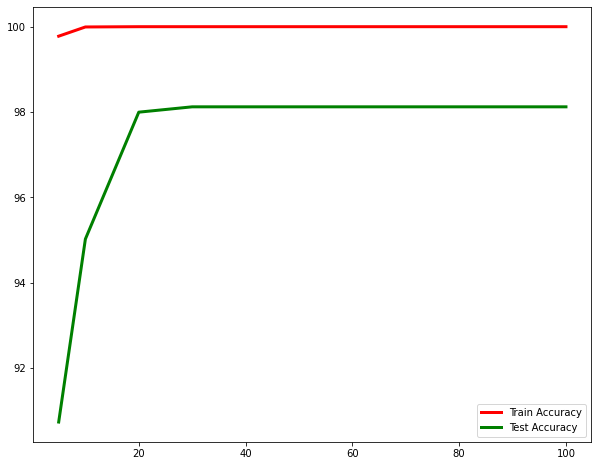

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, train_accuracies, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, test_accuracies, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

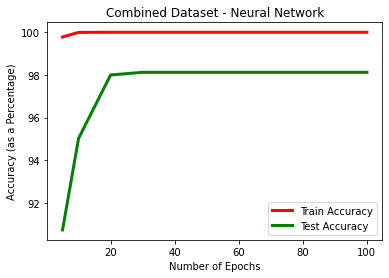

In [37]:
plt.plot(num_epochs_used, train_accuracies, 'r-', lw=3, label='Train Accuracy')
plt.plot(num_epochs_used, test_accuracies, 'g-', lw=3, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (as a Percentage)')
plt.title('Combined Dataset - Neural Network')
plt.legend()

plt.show()